# Santander Product Recommendation

In this competition, there are 1.5 years of customers behavior data from Santander bank to predict what new products customers will purchase. The data starts at 2015-01-28 and has monthly records of products a customer has, such as "credit card", "savings account", etc. The goal is to predict what additional products a customer will get in the last month, 2016-06-28, in addition to what they already have at 2016-05-28. These products are the columns named: ind_(xyz)_ult1, which are the columns #25 - #48 in the training data.

Submissions in this competition are evaluated according to the Mean Average Precision @ 7 (MAP@7). It means that it is needed to predict no more than 7 products for every customer. Note that order matters. But it depends. Order matters only if there is at least one incorrect prediction. In other words, if all predictions are correct, it doesn't matter in which order they are given. This makes sense to show up first the most relevant results.

## Abstract

1. Data exploration and visualization. Trying to understand data, to find some trends in it.
2. Data preprocessing. Preparing train and test data to put them in models. Thinking about missing values.
3. Training and predicting. Trying to apply some models.
    * Some out-of-the-box solution (i.e. XGBoost). Set the result as a baseline score.
    * Trying to beat the baseline score using Collaborative Filtering in Spark.
    * In case of enough time, expirements with Neural Networks.
4. Comparing and Analysis of the Results. Conclusions.

In [ ]:
import csv
import random
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')
from average_precision import apk, mapk

## 1. Data Exploration and Visualization

In [3]:
random.seed(126)
skip_subsample = random.sample(range(1,13647309), 13000000)

In [4]:
data = pd.read_csv('train_ver2.csv', skiprows=skip_subsample)

/home/vasiliy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (5,8,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [31]:
test = pd.read_csv('test_ver2.csv')

/home/vasiliy/.local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
data.head()

,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,...,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
0,2015-01-28,1050616,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
1,2015-01-28,1050591,N,ES,H,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
2,2015-01-28,1050604,N,ES,H,53,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
3,2015-01-28,1050711,N,ES,V,23,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0
4,2015-01-28,1050492,N,ES,V,25,2012-08-10,0.0,35,1.0,...,0,0,0,0,0,0,0,0.0,0.0,0


In [132]:
data.columns

Index([u'fecha_dato', u'ncodpers', u'ind_empleado', u'pais_residencia',
       u'sexo', u'age', u'fecha_alta', u'ind_nuevo', u'antiguedad', u'indrel',
       u'ult_fec_cli_1t', u'indrel_1mes', u'tiprel_1mes', u'indresi',
       u'indext', u'conyuemp', u'canal_entrada', u'indfall', u'tipodom',
       u'cod_prov', u'nomprov', u'ind_actividad_cliente', u'renta',
       u'segmento', u'ind_ahor_fin_ult1', u'ind_aval_fin_ult1',
       u'ind_cco_fin_ult1', u'ind_cder_fin_ult1', u'ind_cno_fin_ult1',
       u'ind_ctju_fin_ult1', u'ind_ctma_fin_ult1', u'ind_ctop_fin_ult1',
       u'ind_ctpp_fin_ult1', u'ind_deco_fin_ult1', u'ind_deme_fin_ult1',
       u'ind_dela_fin_ult1', u'ind_ecue_fin_ult1', u'ind_fond_fin_ult1',
       u'ind_hip_fin_ult1', u'ind_plan_fin_ult1', u'ind_pres_fin_ult1',
       u'ind_reca_fin_ult1', u'ind_tjcr_fin_ult1', u'ind_valo_fin_ult1',
       u'ind_viv_fin_ult1', u'ind_nomina_ult1', u'ind_nom_pens_ult1',
       u'ind_recibo_ult1'],
      dtype='object')

In [129]:
data.ind_recibo_ult1.unique()

array([0, 1])

In [14]:
data.fecha_dato = pd.to_datetime(data.fecha_dato)

In [16]:
len(pd.unique(data.ncodpers))

468570

In [18]:
pd.unique(data.ind_empleado)

array(['N', nan, 'A', 'B', 'F', 'S'], dtype=object)

In [77]:
pd.DataFrame(data.ind_empleado.value_counts()).transpose()

,N,B,F,A,S
ind_empleado,645548,171,159,101,3


In [78]:
pd.DataFrame(data.pais_residencia.value_counts()).transpose()

,ES,AR,DE,GB,FR,CO,US,IT,RO,MX,...,GM,MM,SL,CG,MZ,SK,BZ,BA,KH,LB
pais_residencia,642923,230,217,211,210,179,166,137,122,116,...,1,1,1,1,1,1,1,1,1,1


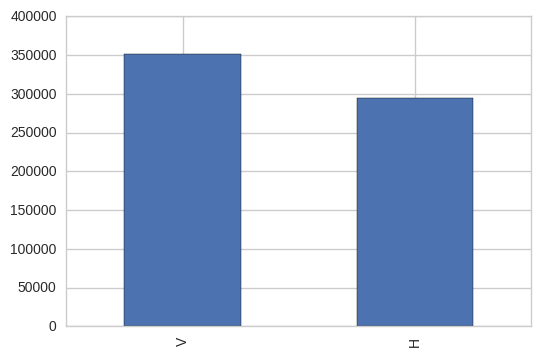

In [56]:
data.sexo.value_counts().plot(kind='bar')

In [64]:
data.age = pd.to_numeric(data.age, errors='coerce')

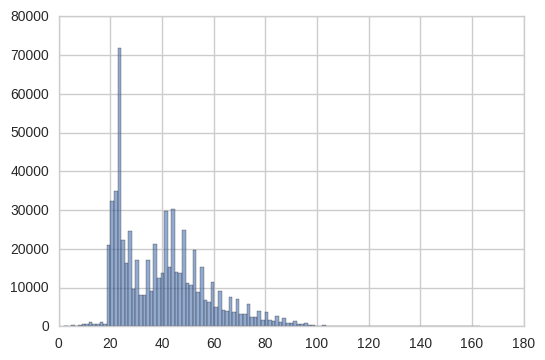

In [69]:
plt.hist(data.age.dropna(), bins=len(pd.unique(data.age.dropna())), alpha = 0.6)
plt.show()

## 2. Data Preprocessing

In [138]:
mapping_dict = {
'ind_empleado'  : {-99:0, 'N':1, 'B':2, 'F':3, 'A':4, 'S':5},
'sexo'          : {'V':0, 'H':1, -99:2},
'ind_nuevo'     : {'0':0, '1':1, -99:2},
'indrel'        : {'1':0, '99':1, -99:2},
'indrel_1mes'   : {-99:0, '1.0':1, '1':1, '2.0':2, '2':2, '3.0':3, '3':3, '4.0':4, '4':4, 'P':5},
'tiprel_1mes'   : {-99:0, 'I':1, 'A':2, 'P':3, 'R':4, 'N':5},
'indresi'       : {-99:0, 'S':1, 'N':2},
'indext'        : {-99:0, 'S':1, 'N':2},
'conyuemp'      : {-99:0, 'S':1, 'N':2},
'indfall'       : {-99:0, 'S':1, 'N':2},
'tipodom'       : {-99:0, '1':1},
'ind_actividad_cliente' : {'0':0, '1':1, -99:2},
'segmento'      : {'02 - PARTICULARES':0, '03 - UNIVERSITARIO':1, '01 - TOP':2, -99:2},
'pais_residencia' : {'LV': 102, 'BE': 12, 'BG': 50, 'BA': 61, 'BM': 117, 'BO': 62, 'JP': 82, 'JM': 116, 'BR': 17, 'BY': 64, 'BZ': 113, 'RU': 43, 'RS': 89, 'RO': 41, 'GW': 99, 'GT': 44, 'GR': 39, 'GQ': 73, 'GE': 78, 'GB': 9, 'GA': 45, 'GN': 98, 'GM': 110, 'GI': 96, 'GH': 88, 'OM': 100, 'HR': 67, 'HU': 106, 'HK': 34, 'HN': 22, 'AD': 35, 'PR': 40, 'PT': 26, 'PY': 51, 'PA': 60, 'PE': 20, 'PK': 84, 'PH': 91, 'PL': 30, 'EE': 52, 'EG': 74, 'ZA': 75, 'EC': 19, 'AL': 25, 'VN': 90, 'ET': 54, 'ZW': 114, 'ES': 0, 'MD': 68, 'UY': 77, 'MM': 94, 'ML': 104, 'US': 15, 'MT': 118, 'MR': 48, 'UA': 49, 'MX': 16, 'IL': 42, 'FR': 8, 'MA': 38, 'FI': 23, 'NI': 33, 'NL': 7, 'NO': 46, 'NG': 83, 'NZ': 93, 'CI': 57, 'CH': 3, 'CO': 21, 'CN': 28, 'CM': 55, 'CL': 4, 'CA': 2, 'CG': 101, 'CF': 109, 'CD': 112, 'CZ': 36, 'CR': 32, 'CU': 72, 'KE': 65, 'KH': 95, 'SV': 53, 'SK': 69, 'KR': 87, 'KW': 92, 'SN': 47, 'SL': 97, 'KZ': 111, 'SA': 56, 'SG': 66, 'SE': 24, 'DO': 11, 'DJ': 115, 'DK': 76, 'DE': 10, 'DZ': 80, 'MK': 105, -99: 1, 'LB': 81, 'TW': 29, 'TR': 70, 'TN': 85, 'LT': 103, 'LU': 59, 'TH': 79, 'TG': 86, 'LY': 108, 'AE': 37, 'VE': 14, 'IS': 107, 'IT': 18, 'AO': 71, 'AR': 13, 'AU': 63, 'AT': 6, 'IN': 31, 'IE': 5, 'QA': 58, 'MZ': 27},
'canal_entrada' : {'013': 49, 'KHP': 160, 'KHQ': 157, 'KHR': 161, 'KHS': 162, 'KHK': 10, 'KHL': 0, 'KHM': 12, 'KHN': 21, 'KHO': 13, 'KHA': 22, 'KHC': 9, 'KHD': 2, 'KHE': 1, 'KHF': 19, '025': 159, 'KAC': 57, 'KAB': 28, 'KAA': 39, 'KAG': 26, 'KAF': 23, 'KAE': 30, 'KAD': 16, 'KAK': 51, 'KAJ': 41, 'KAI': 35, 'KAH': 31, 'KAO': 94, 'KAN': 110, 'KAM': 107, 'KAL': 74, 'KAS': 70, 'KAR': 32, 'KAQ': 37, 'KAP': 46, 'KAW': 76, 'KAV': 139, 'KAU': 142, 'KAT': 5, 'KAZ': 7, 'KAY': 54, 'KBJ': 133, 'KBH': 90, 'KBN': 122, 'KBO': 64, 'KBL': 88, 'KBM': 135, 'KBB': 131, 'KBF': 102, 'KBG': 17, 'KBD': 109, 'KBE': 119, 'KBZ': 67, 'KBX': 116, 'KBY': 111, 'KBR': 101, 'KBS': 118, 'KBP': 121, 'KBQ': 62, 'KBV': 100, 'KBW': 114, 'KBU': 55, 'KCE': 86, 'KCD': 85, 'KCG': 59, 'KCF': 105, 'KCA': 73, 'KCC': 29, 'KCB': 78, 'KCM': 82, 'KCL': 53, 'KCO': 104, 'KCN': 81, 'KCI': 65, 'KCH': 84, 'KCK': 52, 'KCJ': 156, 'KCU': 115, 'KCT': 112, 'KCV': 106, 'KCQ': 154, 'KCP': 129, 'KCS': 77, 'KCR': 153, 'KCX': 120, 'RED': 8, 'KDL': 158, 'KDM': 130, 'KDN': 151, 'KDO': 60, 'KDH': 14, 'KDI': 150, 'KDD': 113, 'KDE': 47, 'KDF': 127, 'KDG': 126, 'KDA': 63, 'KDB': 117, 'KDC': 75, 'KDX': 69, 'KDY': 61, 'KDZ': 99, 'KDT': 58, 'KDU': 79, 'KDV': 91, 'KDW': 132, 'KDP': 103, 'KDQ': 80, 'KDR': 56, 'KDS': 124, 'K00': 50, 'KEO': 96, 'KEN': 137, 'KEM': 155, 'KEL': 125, 'KEK': 145, 'KEJ': 95, 'KEI': 97, 'KEH': 15, 'KEG': 136, 'KEF': 128, 'KEE': 152, 'KED': 143, 'KEC': 66, 'KEB': 123, 'KEA': 89, 'KEZ': 108, 'KEY': 93, 'KEW': 98, 'KEV': 87, 'KEU': 72, 'KES': 68, 'KEQ': 138, -99: 6, 'KFV': 48, 'KFT': 92, 'KFU': 36, 'KFR': 144, 'KFS': 38, 'KFP': 40, 'KFF': 45, 'KFG': 27, 'KFD': 25, 'KFE': 148, 'KFB': 146, 'KFC': 4, 'KFA': 3, 'KFN': 42, 'KFL': 34, 'KFM': 141, 'KFJ': 33, 'KFK': 20, 'KFH': 140, 'KFI': 134, '007': 71, '004': 83, 'KGU': 149, 'KGW': 147, 'KGV': 43, 'KGY': 44, 'KGX': 24, 'KGC': 18, 'KGN': 11}
}

In [139]:
cat_cols = list(mapping_dict.keys())

In [140]:
target_cols = ['ind_ahor_fin_ult1','ind_aval_fin_ult1','ind_cco_fin_ult1','ind_cder_fin_ult1','ind_cno_fin_ult1','ind_ctju_fin_ult1','ind_ctma_fin_ult1','ind_ctop_fin_ult1','ind_ctpp_fin_ult1','ind_deco_fin_ult1','ind_deme_fin_ult1','ind_dela_fin_ult1','ind_ecue_fin_ult1','ind_fond_fin_ult1','ind_hip_fin_ult1','ind_plan_fin_ult1','ind_pres_fin_ult1','ind_reca_fin_ult1','ind_tjcr_fin_ult1','ind_valo_fin_ult1','ind_viv_fin_ult1','ind_nomina_ult1','ind_nom_pens_ult1','ind_recibo_ult1']
target_cols = target_cols[2:]

In [141]:
def getTarget(row):
    tlist = []
    for col in target_cols:
        if row[col].strip() in ['', 'NA']:
            target = 0
        else:
            target = int(float(row[col]))
        tlist.append(target)
    return tlist

In [142]:
def getIndex(row, col):
    val = row[col].strip()
    if val not in ['','NA']:
        ind = mapping_dict[col][val]
    else:
        ind = mapping_dict[col][-99]
    return ind

In [143]:
def getAge(row):
    mean_age = 40.
    min_age = 20.
    max_age = 90.
    range_age = max_age - min_age
    age = row['age'].strip()
    if age == 'NA' or age == '':
        age = mean_age
    else:
        age = float(age)
        if age < min_age:
            age = min_age
        elif age > max_age:
            age = max_age
    return round( (age - min_age) / range_age, 4)

In [144]:
def getCustSeniority(row):
    min_value = 0.
    max_value = 256.
    range_value = max_value - min_value
    missing_value = 0.
    cust_seniority = row['antiguedad'].strip()
    if cust_seniority == 'NA' or cust_seniority == '':
        cust_seniority = missing_value
    else:
        cust_seniority = float(cust_seniority)
        if cust_seniority < min_value:
            cust_seniority = min_value
        elif cust_seniority > max_value:
            cust_seniority = max_value
    return round((cust_seniority-min_value) / range_value, 4)

In [145]:
def getRent(row):
    min_value = 0.
    max_value = 1500000.
    range_value = max_value - min_value
    missing_value = 101850.
    rent = row['renta'].strip()
    if rent == 'NA' or rent == '':
        rent = missing_value
    else:
        rent = float(rent)
        if rent < min_value:
            rent = min_value
        elif rent > max_value:
            rent = max_value
    return round((rent-min_value) / range_value, 6)

In [146]:
def getTime(row):
    min_value = 0
    max_value = 100.0*365
    range_value = max_value - min_value
    start_time = row['fecha_alta'].strip()
    stop_time = row['fecha_dato'].strip()
    try:
        if start_time[0] == '':
            start_time = start_time[1:]
        if stop_time[0] == '':
            stop_time = stop_time[1:]
        temp = (int(stop_time[:stop_time.find('-')])-int(start_time[:start_time.find('-')]))*365
        temp += (int(stop_time[stop_time.find('-'):stop_time.find('-',stop_time.find('-'))]) - 
                 int(start_time[start_time.find('-'):start_time.find('-',start_time.find('-'))])) * 30
        if temp <min_value :
            temp = min_value
        if temp > max_value:
            temp = max_value
        return round((temp-min_value) / range_value, 6)
    except:
        return 0.1

In [147]:
def processData(in_file_name, cust_dict):
    x_vars_list = []
    y_vars_list = []
    for row in csv.DictReader(in_file_name):
        # use only the four months as specified by breakfastpirate #
        if row['fecha_dato'] not in ['2015-05-28', '2015-06-28', '2016-05-28', '2016-06-28']:
            continue

        cust_id = int(row['ncodpers'])
        if row['fecha_dato'] in ['2015-05-28', '2016-05-28']:
            target_list = getTarget(row)
            cust_dict[cust_id] =  target_list[:]
            continue

        x_vars = []
        for col in cat_cols:
            x_vars.append( getIndex(row, col) )
        x_vars.append( getAge(row) )
        x_vars.append( getCustSeniority(row) )
        x_vars.append( getRent(row) )
        x_vars.append( getTime(row) )

        if row['fecha_dato'] == '2016-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            x_vars_list.append(x_vars + prev_target_list)
        elif row['fecha_dato'] == '2015-06-28':
            prev_target_list = cust_dict.get(cust_id, [0]*22)
            target_list = getTarget(row)
            new_products = [max(x1 - x2,0) for (x1, x2) in zip(target_list, prev_target_list)]
            if sum(new_products) > 0:
                for ind, prod in enumerate(new_products):
                    if prod>0:
                        assert len(prev_target_list) == 22
                        x_vars_list.append(x_vars+prev_target_list)
                        y_vars_list.append(ind)

    return x_vars_list, y_vars_list, cust_dict

## 3. Training and Predicting

### XGBoost

In [148]:
def runXGB(train_X, train_y, seed_val=123):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.05
    param['max_depth'] = 4
    param['silent'] = 1
    param['num_class'] = 22
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = 2
    param['subsample'] = 0.9
    param['colsample_bytree'] = 0.9
    param['seed'] = seed_val
    num_rounds = 190

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)
    model = xgb.train(plst, xgtrain, num_rounds)
    return model

In [149]:
start_time = datetime.datetime.now()
train_file = open("train_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(train_file, {})
train_X = np.array(x_vars_list)
train_y = np.array(y_vars_list)
print(np.unique(train_y))
del x_vars_list, y_vars_list
train_file.close()
print(train_X.shape, train_y.shape)
test_file = open("test_ver2.csv")
x_vars_list, y_vars_list, cust_dict = processData(test_file, cust_dict)
test_X = np.array(x_vars_list)
del x_vars_list
test_file.close()
print(test_X.shape)
print("Building model..")
model = runXGB(train_X, train_y, seed_val=0)
del train_X, train_y
print("Predicting..")
xgtest = xgb.DMatrix(test_X)
preds = model.predict(xgtest)
del test_X, xgtest
print("Getting the top products..")
target_cols = np.array(target_cols)
preds = np.argsort(preds, axis=1)
preds = np.fliplr(preds)[:,:7]
test_id = np.array(pd.read_csv("test_ver2.csv", usecols=['ncodpers'])['ncodpers'])
final_preds = [" ".join(list(target_cols[pred])) for pred in preds]
out_df = pd.DataFrame.from_items([('ncodpers', test_id), ('added_products', final_preds)])
out_df.to_csv('sub_xgb_time.csv', index=False)
print(datetime.datetime.now()-start_time)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
((45679, 41), (45679,))
(929615, 41)
Building model..
Predicting..
Getting the top products..
0:29:08.388332


## 4. Comparing and Analysis of the Results

... ToDo